In [494]:
import numpy as np
import matplotlib.pyplot as plt


K = 100.0
sigma = 0.2
r = 0.05
q = 0.06

S_min = 50.0
S_max = 150.0

x_min = np.log(S_min)
x_max = np.log(S_max)

N = 400
dx = (x_max - x_min) / (N-1)

T = 1
M = 400
dtau = T / (M-1)

a_one = -(((sigma ** 2) * dtau) / (4 * (dx ** 2))) - ((r - q - ((sigma ** 2) / 2)) * (dtau / (4 * dx)))

a_zero = 1 + (((sigma ** 2) / 2) * (dtau / (dx ** 2))) + ((r / 2) * dtau)

a_negative_one = -(((sigma ** 2) * dtau) / (4 * (dx ** 2))) + ((r - q - ((sigma ** 2) / 2)) * (dtau / (4 * dx)))

b_one = (((sigma ** 2) / 4) * (dtau / (dx ** 2))) + ((r - q - ((sigma ** 2) / 2)) * (dtau / (4 * dx)))

b_zero = 1 - (((sigma ** 2) / 2) * (dtau / (dx ** 2))) - ((r / 2) * dtau)

b_negative_one = (((sigma ** 2) / 4) * (dtau / (dx ** 2))) - ((r - q - ((sigma ** 2) / 2)) * (dtau / (4 * dx)))

omega = 1.5
epsilon = 1e-8

In [495]:
# Payoff function for American put
def Put_Payoff(j):
    return max(K - np.exp(x_min + dx * j), 0)

def Put_Left_Boundary(j):
    return (K - np.exp(x_min - dx))


def American_Put_Price():
    A = np.zeros((N, N)) # Tri-diagonal matrix filled with a_zero, a_negative_one, and a_one
    B = np.zeros((N, N)) # Tridiagonal matrix filled with b_zero, b_negative_one, b_one
    V = np.zeros((M, N))
   
    for j in range(N):
        A[j, j] = a_zero
        if j < N - 1:
            A[j, j + 1] = a_one
            A[j + 1, j] = a_negative_one
    
    for j in range(N):
        B[j, j] = b_zero
        if j < N - 1:
            B[j, j + 1] = b_one
            B[j + 1, j] = b_negative_one
    
    # Initial conditions
    for j in range(N):
        V[0, j] = Put_Payoff(j)

    for i in range(1, M):
        error = float("inf")
        v_psor = V[i-1].copy()
        d = np.dot(B, V[i-1])
        d[0] += b_negative_one * Put_Left_Boundary(i-1) - a_negative_one * Put_Left_Boundary(i)
        while epsilon < error:
            v_psor_prev = v_psor.copy()
            for j in range(N):
                correction = d[j] - a_zero * v_psor[j]
                if 0 < j:
                    correction -= a_negative_one * v_psor[j-1]
                if j < N-1:
                    correction -= a_one * v_psor[j+1]
                v_psor[j] += (omega / a_zero) * correction
                v_psor[j] = max(v_psor[j], Put_Payoff(j))
            diff = v_psor - v_psor_prev
            error = np.dot(diff, diff)
        V[i] = v_psor
    return V        

In [496]:
put_price = American_Put_Price()

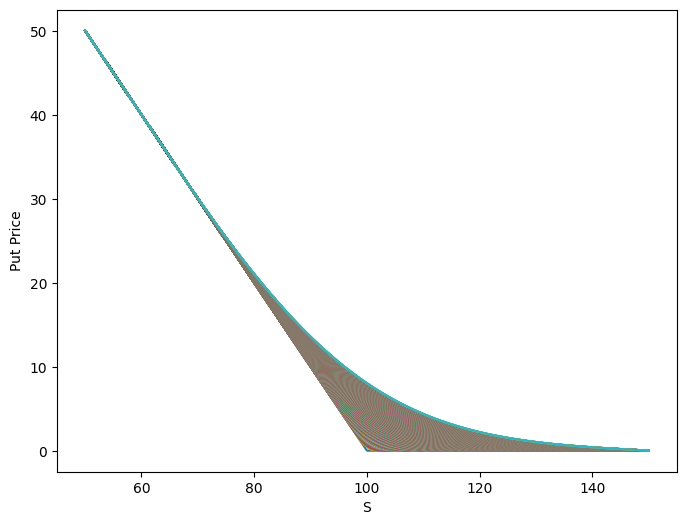

In [497]:
ax = plt.figure(figsize=([8,6])).add_subplot()
x = np.exp(x_min + dx * np.arange(N))
for i in range(M):
    y = put_price[i]
    ax.plot(x, y)
    ax.set_xlabel('S')
    ax.set_ylabel('Put Price')


In [498]:
put_exercise_boundary = np.full((M), K)
for i in range(M):
    for j in range(N):
        if put_price[i, j] > Put_Payoff(j):
            put_exercise_boundary[i] = np.exp(x_min + dx * j)
            break

Text(0, 0.5, 'Put exercise boundary')

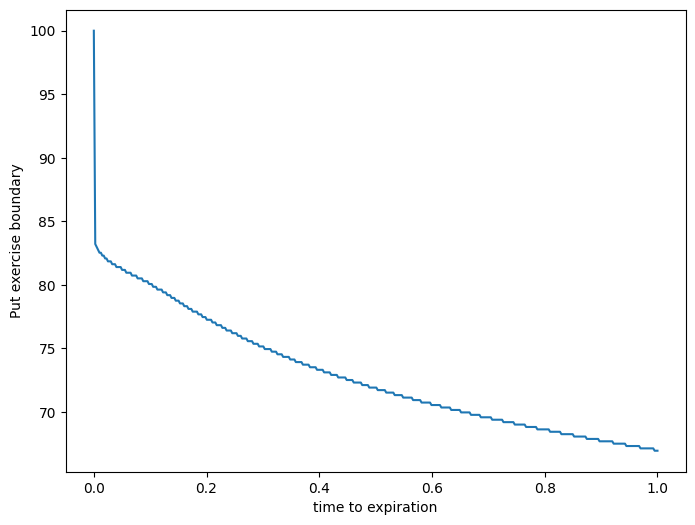

In [499]:
ax = plt.figure(figsize=([8,6])).add_subplot()
x = (dtau * np.arange(M))
y = put_exercise_boundary
ax.plot(x, y)
ax.set_xlabel('time to expiration')
ax.set_ylabel('Put exercise boundary')

In [500]:
def Call_Payoff(j):
    return max(np.exp(x_min + dx * j) - K, 0)

def Call_Right_Boundary(j):
    return (np.exp(x_max + dx) - K)


def American_Call_Price():
    A = np.zeros((N, N))
    B = np.zeros((N, N))
    V = np.zeros((M, N))
   
    for j in range(N):
        A[j, j] = a_zero
        if j < N - 1:
            A[j, j + 1] = a_one
            A[j + 1, j] = a_negative_one
    
    for j in range(N):
        B[j, j] = b_zero
        if j < N - 1:
            B[j, j + 1] = b_one
            B[j + 1, j] = b_negative_one
    
    for j in range(N):
        V[0, j] = Call_Payoff(j)

    for i in range(1, M):
        error = float("inf")
        v_psor = V[i-1].copy()
        d = np.dot(B, V[i-1])
        # Crank-Nicolson stencil at boundaries. Eq. 6.2.8.
        d[N-1] += b_one * Call_Right_Boundary(i-1) - a_one * Call_Right_Boundary(i)
        while epsilon < error:
            v_psor_prev = v_psor.copy()
            for j in range(N):
                # Eq 6.2.23.
                correction = d[j] - a_zero * v_psor[j]
                if 0 < j:
                    correction -= a_negative_one * v_psor[j-1]
                if j < N-1:
                    correction -= a_one * v_psor[j+1]
                v_psor[j] += (omega / a_zero) * correction
                v_psor[j] = max(v_psor[j], Call_Payoff(j))
            diff = v_psor - v_psor_prev
            error = np.dot(diff, diff)
        V[i] = v_psor
    return V

In [501]:
call_price = American_Call_Price()

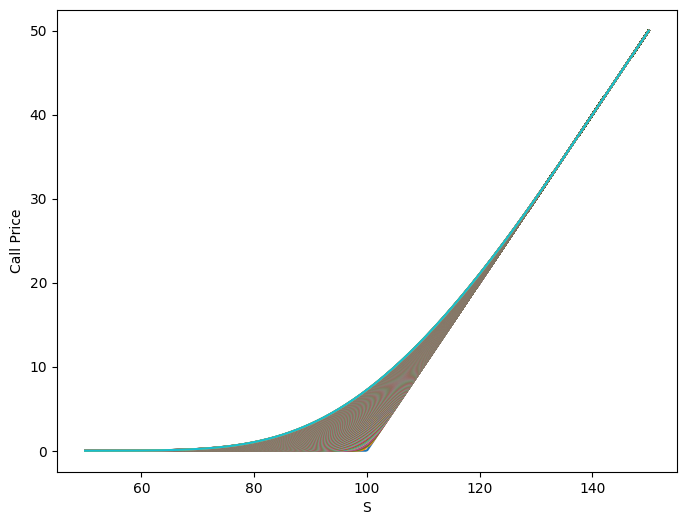

In [502]:
ax = plt.figure(figsize=([8,6])).add_subplot()
x = np.exp(x_min + dx * np.arange(N))
for i in range(M):
    y = call_price[i]
    ax.plot(x, y)
    ax.set_xlabel('S')
    ax.set_ylabel('Call Price')

In [503]:
call_exercise_boundary = np.full((M), K)
for i in range(1, M):
    for j in reversed(range(N)):
        if call_price[i, j] > Call_Payoff(j):
            call_exercise_boundary[i] = np.exp(x_min + dx * j)
            break

Text(0, 0.5, 'Call exercise boundary')

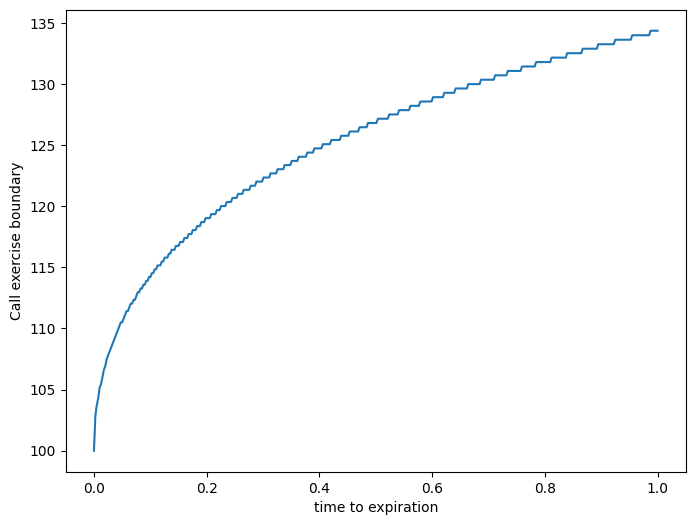

In [504]:
    ax = plt.figure(figsize=([8,6])).add_subplot()
    x = (dtau * np.arange(M))
    y = call_exercise_boundary
    ax.plot(x, y)
    ax.set_xlabel('time to expiration')
    ax.set_ylabel('Call exercise boundary')

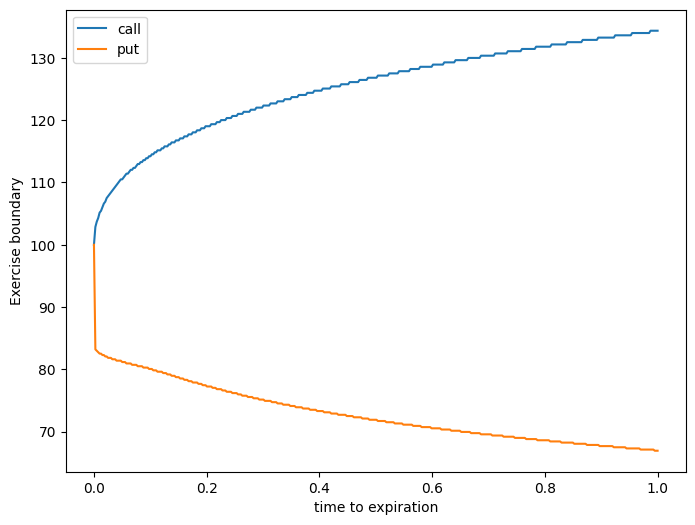

In [505]:
    ax = plt.figure(figsize=([8,6])).add_subplot()
    x = (dtau * np.arange(M))
    y = call_exercise_boundary
    ax.plot(x, y, label='call')
    y = put_exercise_boundary
    ax.plot(x,y, label='put')
    ax.set_xlabel('time to expiration')
    ax.set_ylabel('Exercise boundary')
    plt.legend()